In [1]:
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import libpysal
from esda.moran import Moran
from esda.moran import Moran_Local
import mapclassify
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from shapely.ops import unary_union
from shapely.geometry import MultiLineString
from adjustText import adjust_text
import time
from scipy.stats import pearsonr

In [2]:
start_time = time.time()

In [3]:

# Load data


# Population centroids (reference table)
centroids_df = pd.read_csv('lsoa_population_centroids.csv')
valid_lsoa_list = centroids_df['LSOA21CD'].unique()

# LSOA boundaries, keep only valid LSOAs
lsoa_gdf = gpd.read_file('Lower_layer_Super_Output_Areas_(December_2021)_Boundaries_EW_BFC_(V10).shp')
lsoa_gdf = lsoa_gdf[lsoa_gdf['LSOA21CD'].isin(valid_lsoa_list)]

# IMD + 65+ population, keep only valid LSOAs
socio_df = pd.read_csv('IMD_65plus_merged.csv')
socio_df = socio_df[socio_df['LSOA21CD'].isin(valid_lsoa_list)]

# LSOA-to-district mapping table — keep only valid LSOAs
lookup_df = pd.read_csv('LSOA_(2011)_to_LSOA_(2021)_to_Local_Authority_District_(2022)_Exact_Fit_Lookup_for_EW_(V3).csv')
lookup_df = lookup_df[lookup_df['LSOA21CD'].isin(valid_lsoa_list)]

# Cultural facilities data
facilities_df = pd.read_csv('CIM 2023 Museums and public galleries (Nov 2023).csv')
facilities_df['name_lower'] = facilities_df['name'].str.lower()

In [4]:
print(len(lsoa_gdf))          # Total number of LSOAs after merging
    
print(len(centroids_df))     # Number of LSOAs in the original population centroid table

35671
35671


In [5]:
npg_row = facilities_df[facilities_df['name_lower'].str.contains('national portrait gallery', na=False)]
ica_row = facilities_df[facilities_df['name_lower'].str.contains('institute of contemporary arts', na=False)]

if not npg_row.empty and not ica_row.empty:
    npg_coords = (npg_row['longitude'].values[0], npg_row['latitude'].values[0])
    ica_coords = (ica_row['longitude'].values[0], ica_row['latitude'].values[0])
    print(f"NPG：{npg_coords}")
    print(f"ICA：{ica_coords}")
else:
    raise ValueError("NPG or ICA not matched successfully — please check the facility data")

NPG：(np.float64(-0.126871767), np.float64(51.50888716))
ICA：(np.float64(-0.13092159), np.float64(51.506388))


In [6]:
# Prepare road network and nodes




# Retrieve walking road network for Central London
G = ox.graph_from_place('London, UK', network_type='walk')

In [7]:
# Add nearest road network node to each population centroid
centroids_df['nearest_node'] = ox.distance.nearest_nodes(G, centroids_df['pop_centroid_x'], centroids_df['pop_centroid_y'])

In [8]:
# Define coordinates of cultural facilities
npg_coords = (-0.126871767, 51.50888716)
ica_coords = (-0.13092159, 51.506388)

In [9]:
# Match each cultural facility to its nearest network node
npg_node = ox.distance.nearest_nodes(G, *npg_coords)
ica_node = ox.distance.nearest_nodes(G, *ica_coords)

In [10]:
# Batch precompute shortest path length dictionaries to NPG and ICA
lengths_to_npg = nx.single_source_dijkstra_path_length(G, npg_node, weight='length')
lengths_to_ica = nx.single_source_dijkstra_path_length(G, ica_node, weight='length')

In [11]:
# Map distances
centroids_df['dist_to_npg'] = centroids_df['nearest_node'].map(lengths_to_npg).fillna(float('inf'))
centroids_df['dist_to_ica'] = centroids_df['nearest_node'].map(lengths_to_ica).fillna(float('inf'))

In [12]:
# Calculate CPI indicator

EPSILON = 1e-6
valid_npg = centroids_df['dist_to_npg'] != float('inf')
valid_ica = centroids_df['dist_to_ica'] != float('inf')

centroids_df.loc[valid_npg, 'CPI_npg'] = 1 - (centroids_df.loc[valid_npg, 'dist_to_npg'] - centroids_df.loc[valid_npg, 'dist_to_npg'].min()) / (centroids_df.loc[valid_npg, 'dist_to_npg'].max() - centroids_df.loc[valid_npg, 'dist_to_npg'].min() + EPSILON)
centroids_df.loc[~valid_npg, 'CPI_npg'] = 0

centroids_df.loc[valid_ica, 'CPI_ica'] = 1 - (centroids_df.loc[valid_ica, 'dist_to_ica'] - centroids_df.loc[valid_ica, 'dist_to_ica'].min()) / (centroids_df.loc[valid_ica, 'dist_to_ica'].max() - centroids_df.loc[valid_ica, 'dist_to_ica'].min() + EPSILON)
centroids_df.loc[~valid_ica, 'CPI_ica'] = 0

print(centroids_df.head())

    LSOA21CD  pop_centroid_x  pop_centroid_y  nearest_node   dist_to_npg  \
0  E01000001       -0.096502       51.519248    2415274415   3681.404592   
1  E01000002       -0.092420       51.519393    2940401398   4209.198522   
2  E01000003       -0.096102       51.521617    2415274415   3681.404592   
3  E01000005       -0.076355       51.514456    9673189935   5821.543542   
4  E01000006        0.088073       51.538997      26422715  19383.150134   

    dist_to_ica   CPI_npg   CPI_ica  
0   4182.960170  0.907152  0.906876  
1   4710.754101  0.892928  0.892656  
2   4182.960170  0.907152  0.906876  
3   6230.858899  0.849475  0.851701  
4  19884.705713  0.483983  0.483835  


In [13]:
# Calculate proportion of population aged 65+

pop_df = pd.read_csv('population_mid-2021.csv', thousands=',')

In [14]:
# Convert to numeric
cols_to_numeric = ['Total', 'F65 and over', 'M65 and over']
pop_df[cols_to_numeric] = pop_df[cols_to_numeric].apply(pd.to_numeric, errors='coerce')

In [15]:
# rate
pop_df['pop_65plus'] = pop_df['F65 and over'] + pop_df['M65 and over']
pop_df['prop_65plus'] = pop_df['pop_65plus'] / pop_df['Total']

In [16]:
pop_df = pop_df[['LSOA 2021 Code', 'pop_65plus', 'Total', 'prop_65plus']]
pop_df.rename(columns={'LSOA 2021 Code': 'LSOA21CD', 'Total': 'pop_total'}, inplace=True)

In [17]:
print(pop_df.head())
print(pop_df.dtypes)

    LSOA21CD  pop_65plus  pop_total  prop_65plus
0  E01011949         314       1854     0.169364
1  E01011950         169       1037     0.162970
2  E01011951         154       1203     0.128013
3  E01011952         325       1610     0.201863
4  E01011953         288       1970     0.146193
LSOA21CD        object
pop_65plus       int64
pop_total        int64
prop_65plus    float64
dtype: object


In [18]:
# Check for duplicate fields
print(socio_df.columns)

socio_df = socio_df.drop(columns=['pop_65plus'], errors='ignore')

Index(['LSOA21CD', 'Index of Multiple Deprivation (IMD) Score', 'pop_65plus'], dtype='object')


In [19]:
print(socio_df.columns)

Index(['LSOA21CD', 'Index of Multiple Deprivation (IMD) Score'], dtype='object')


In [20]:
# Merge population information
full_df = centroids_df.merge(pop_df, on='LSOA21CD', how='left')

# Merge population information
full_df = full_df.merge(socio_df, on='LSOA21CD', how='left')

# Merge administrative district information
full_df = full_df.merge(lookup_df[['LSOA21CD', 'LAD22NM']], on='LSOA21CD', how='left')

In [21]:
print(full_df.columns)

Index(['LSOA21CD', 'pop_centroid_x', 'pop_centroid_y', 'nearest_node',
       'dist_to_npg', 'dist_to_ica', 'CPI_npg', 'CPI_ica', 'pop_65plus',
       'pop_total', 'prop_65plus', 'Index of Multiple Deprivation (IMD) Score',
       'LAD22NM'],
      dtype='object')


In [22]:
# Filter for two districts
full_df = full_df[full_df['LAD22NM'].isin(['Tower Hamlets', 'Richmond upon Thames'])].copy()

In [23]:
# missing value
print(full_df.isna().sum())

LSOA21CD                                     0
pop_centroid_x                               0
pop_centroid_y                               0
nearest_node                                 0
dist_to_npg                                  0
dist_to_ica                                  0
CPI_npg                                      0
CPI_ica                                      0
pop_65plus                                   0
pop_total                                    0
prop_65plus                                  0
Index of Multiple Deprivation (IMD) Score    0
LAD22NM                                      0
dtype: int64


In [24]:
# # Calculate weighted CPI

full_df['CPI_npg_65plus_prop'] = full_df['CPI_npg'] * full_df['prop_65plus']
full_df['CPI_ica_65plus_prop'] = full_df['CPI_ica'] * full_df['prop_65plus']

In [25]:
focus_df = full_df[full_df['LAD22NM'].isin(['Tower Hamlets', 'Richmond upon Thames'])]

summary = focus_df.groupby('LAD22NM')[['Index of Multiple Deprivation (IMD) Score','CPI_npg_65plus_prop', 'CPI_ica_65plus_prop']].mean()
print(summary)

                      Index of Multiple Deprivation (IMD) Score  \
LAD22NM                                                           
Richmond upon Thames                                   9.423478   
Tower Hamlets                                         27.712571   

                      CPI_npg_65plus_prop  CPI_ica_65plus_prop  
LAD22NM                                                         
Richmond upon Thames             0.088618             0.092308  
Tower Hamlets                    0.044122             0.044306  


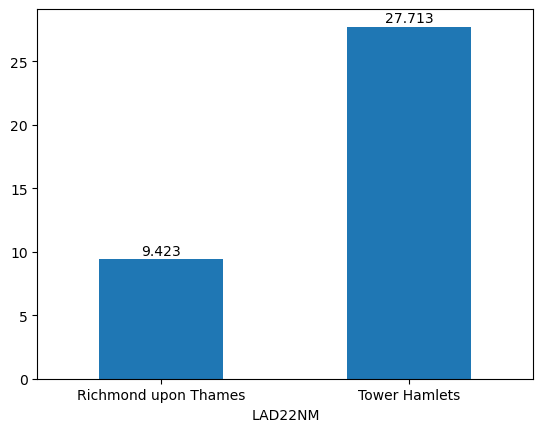

In [26]:

ax = summary['Index of Multiple Deprivation (IMD) Score'].plot(kind='bar')

plt.xticks(rotation=0)

for idx, value in enumerate(summary['Index of Multiple Deprivation (IMD) Score']):
    ax.text(idx, value + 0.1, round(value, 3), ha='center', va='bottom')

plt.savefig('Result/IMD Score By Borough.png', dpi=300)    
plt.show()

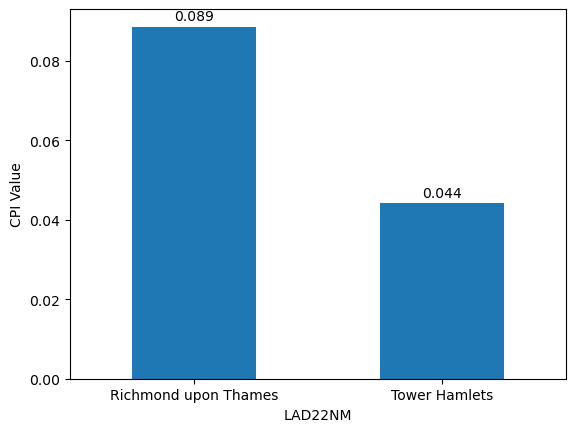

In [27]:
ax = summary['CPI_npg_65plus_prop'].plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('CPI Value')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 0.0008, 
            round(p.get_height(), 3), 
            ha='center', va='bottom')
plt.savefig('Result/Weighted CPI to NPG by Borough', dpi=300) 
plt.show()

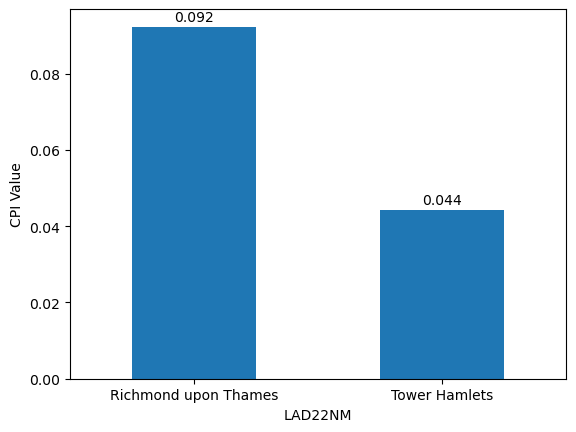

In [28]:
ax = summary['CPI_ica_65plus_prop'].plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel('CPI Value')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, 
            p.get_height() + 0.0008, 
            round(p.get_height(), 3), 
            ha='center', va='bottom')
plt.savefig('Result/Weighted CPI to ICA by Borough', dpi=300) 
plt.show()

In [29]:
print(full_df.columns)

Index(['LSOA21CD', 'pop_centroid_x', 'pop_centroid_y', 'nearest_node',
       'dist_to_npg', 'dist_to_ica', 'CPI_npg', 'CPI_ica', 'pop_65plus',
       'pop_total', 'prop_65plus', 'Index of Multiple Deprivation (IMD) Score',
       'LAD22NM', 'CPI_npg_65plus_prop', 'CPI_ica_65plus_prop'],
      dtype='object')


In [30]:
# Merge cultural accessibility indicators with boundaries

full_df = full_df.rename(columns={'pop_65plus_x': 'pop_65plus'})

# Merge
lsoa_gdf = lsoa_gdf.merge(full_df[['LSOA21CD', 'CPI_npg', 'CPI_ica', 'Index of Multiple Deprivation (IMD) Score', 'pop_65plus']], on='LSOA21CD', how='left')
lsoa_gdf = lsoa_gdf.merge(lookup_df[['LSOA21CD', 'LAD22NM']], on='LSOA21CD', how='left')

# Filter spatial boundaries for two districts
focus_gdf = lsoa_gdf[lsoa_gdf['LAD22NM'].isin(['Tower Hamlets', 'Richmond upon Thames'])]

In [31]:
# Unify coordinate reference system for cultural facility points


facilities = gpd.GeoDataFrame({
    'name': ['NPG', 'ICA'],
    'geometry': [Point(npg_coords), Point(ica_coords)]
}, crs='EPSG:4326')

facilities = facilities.to_crs(focus_gdf.crs)

In [32]:
# pip install adjustText

In [33]:
print(lookup_df.columns)

Index(['LSOA11CD', 'LSOA11NM', 'LSOA21CD', 'LSOA21NM', 'CHGIND', 'LAD22CD',
       'LAD22NM', 'LAD22NMW', 'ObjectId'],
      dtype='object')


In [34]:
# Merge cultural accessibility and weighted exposure indicators with boundaries
lsoa_gdf = lsoa_gdf[['LSOA21CD', 'geometry']]

lsoa_gdf = lsoa_gdf.merge(
    full_df[['LSOA21CD', 'CPI_npg', 'CPI_ica', 'CPI_npg_65plus_prop', 'CPI_ica_65plus_prop',
             'Index of Multiple Deprivation (IMD) Score', 'pop_65plus', 'prop_65plus']],
    on='LSOA21CD', how='left'
)

In [35]:
print(lsoa_gdf.columns)

Index(['LSOA21CD', 'geometry', 'CPI_npg', 'CPI_ica', 'CPI_npg_65plus_prop',
       'CPI_ica_65plus_prop', 'Index of Multiple Deprivation (IMD) Score',
       'pop_65plus', 'prop_65plus'],
      dtype='object')


In [36]:
lsoa_gdf = lsoa_gdf.merge(lookup_df[['LSOA21CD', 'LAD22NM']], on='LSOA21CD', how='left')

focus_gdf = lsoa_gdf[lsoa_gdf['LAD22NM'].isin(['Tower Hamlets', 'Richmond upon Thames'])]

In [37]:
print(focus_gdf.columns.tolist())

['LSOA21CD', 'geometry', 'CPI_npg', 'CPI_ica', 'CPI_npg_65plus_prop', 'CPI_ica_65plus_prop', 'Index of Multiple Deprivation (IMD) Score', 'pop_65plus', 'prop_65plus', 'LAD22NM']


In [38]:
def plot_map_with_facilities(gdf, column, facilities_gdf=None, title=None, cmap='YlGnBu', filename=None):
    import matplotlib.pyplot as plt
    from adjustText import adjust_text

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    gdf.plot(column=column, ax=ax, cmap=cmap, legend=True, edgecolor='grey', linewidth=0.2)


    if facilities_gdf is not None:
        facilities_gdf.plot(ax=ax, color='red', markersize=30, marker='o', label='Cultural Facility')


        if 'name' in facilities_gdf.columns:
            texts = []
            for x, y, label in zip(facilities_gdf.geometry.x, facilities_gdf.geometry.y, facilities_gdf['name']):
                texts.append(ax.text(x, y, label, fontsize=8, fontweight='bold', color='red'))
            adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))


    if title:
        ax.set_title(title, fontsize=14)

    ax.axis('off')
    ax.legend(loc='lower right')


    if filename:
        plt.tight_layout()
        plt.savefig(filename, dpi=300)

    plt.show()


In [39]:
print(focus_gdf[['CPI_npg_65plus_prop', 'CPI_ica_65plus_prop']].describe())

       CPI_npg_65plus_prop  CPI_ica_65plus_prop
count           410.000000           410.000000
mean              0.062440             0.063548
std               0.033183             0.034210
min               0.000000             0.000000
25%               0.039900             0.039888
50%               0.062765             0.063827
75%               0.088231             0.088204
max               0.191636             0.197314


In [40]:
print(focus_gdf.columns.tolist())

['LSOA21CD', 'geometry', 'CPI_npg', 'CPI_ica', 'CPI_npg_65plus_prop', 'CPI_ica_65plus_prop', 'Index of Multiple Deprivation (IMD) Score', 'pop_65plus', 'prop_65plus', 'LAD22NM']


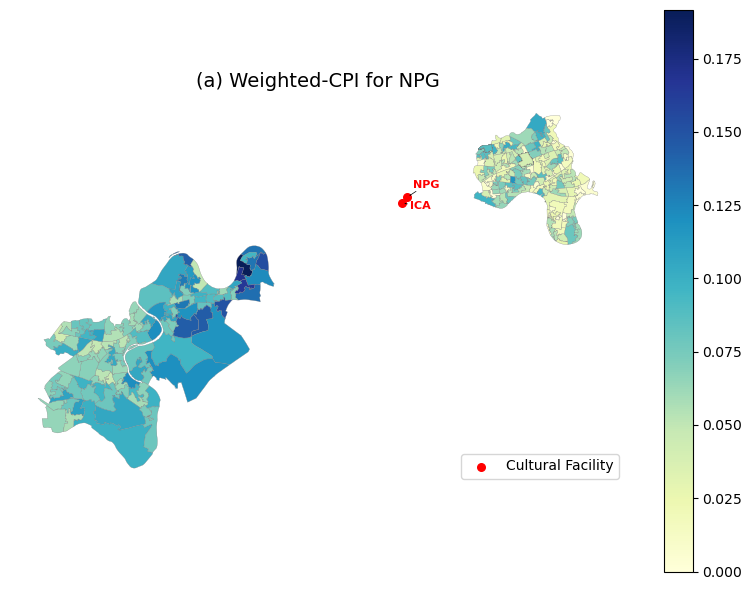

In [41]:
# NPG
plot_map_with_facilities(
    gdf=focus_gdf,
    column='CPI_npg_65plus_prop',
    facilities_gdf=facilities,
    title='(a) Weighted-CPI for NPG',
    filename='Result/weighted_CPI_NPG.png'
)

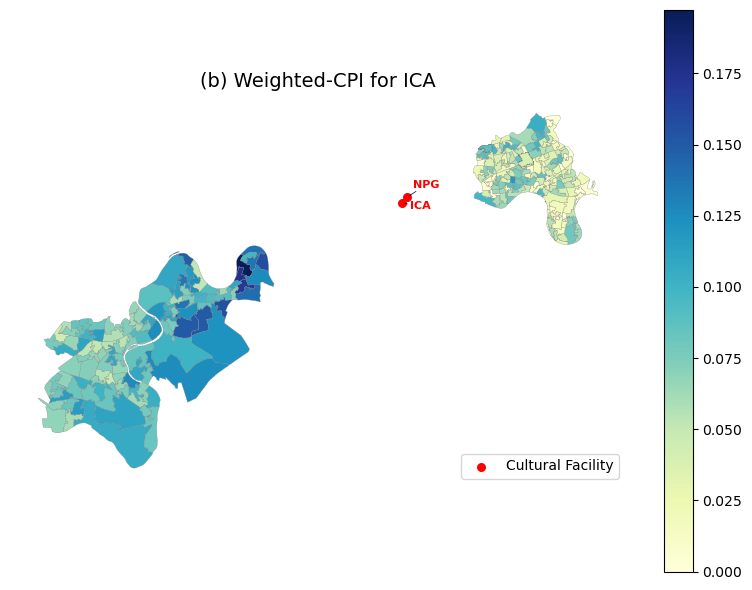

In [42]:
# ICA
plot_map_with_facilities(
    gdf=focus_gdf,
    column='CPI_ica_65plus_prop',
    facilities_gdf=facilities,
    title='(b) Weighted-CPI for ICA',
    filename='Result/weighted_CPI_ICA.png'
)


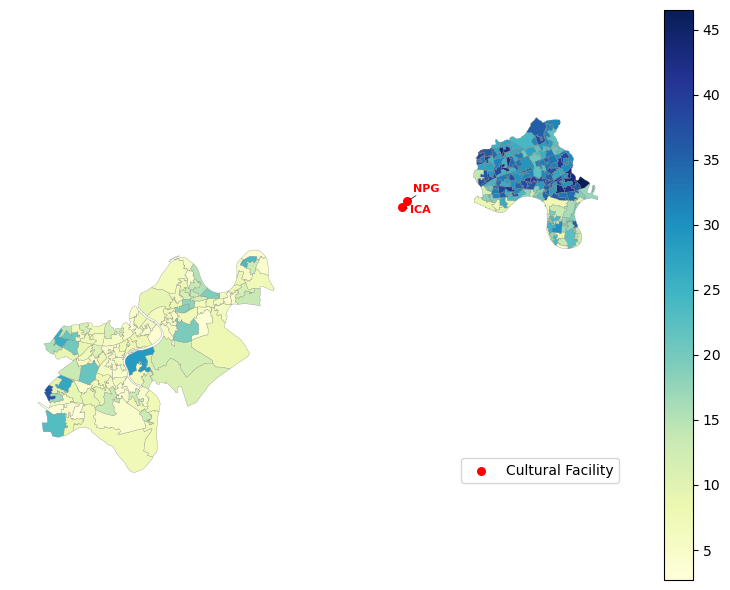

In [43]:
# IMD
plot_map_with_facilities(
    gdf=focus_gdf,
    column='Index of Multiple Deprivation (IMD) Score',
    facilities_gdf=facilities,

    filename='Result/IMD Spatial Distribution.png'
)


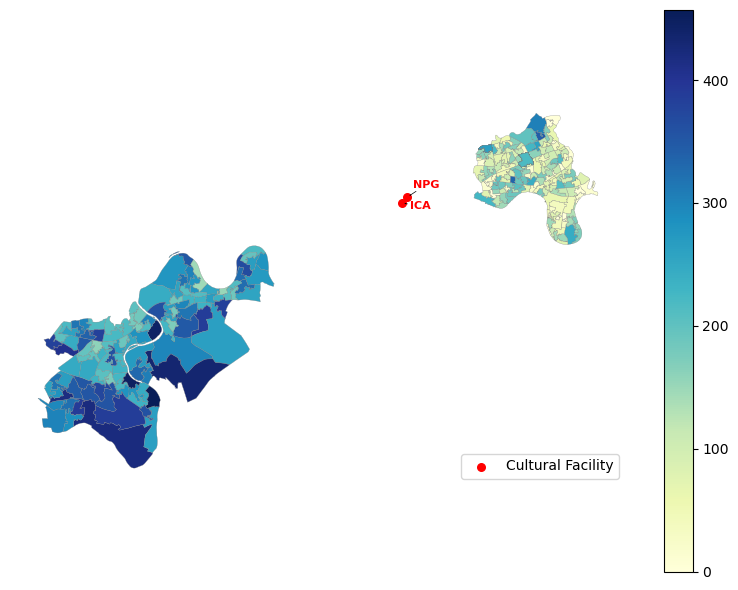

In [44]:
# the rate of older adults
plot_map_with_facilities(
    gdf=focus_gdf,
    column='pop_65plus',
    facilities_gdf=facilities,

    filename='Result/Population_aged_65+(%).png'
)


c:\Users\zhouzhou\anaconda3\envs\urbsim\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


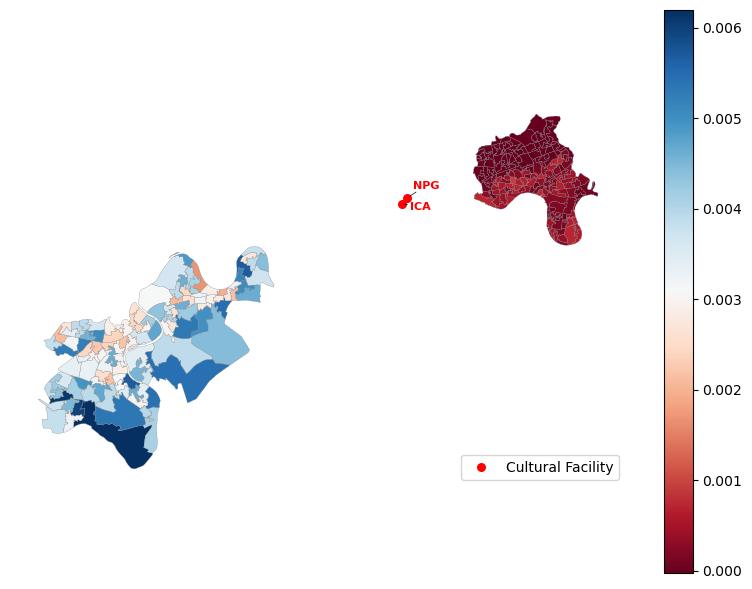

In [45]:
# Create a difference map (ICA - NPG) to highlight "who is more accessible"
focus_gdf['CPI_diff'] = focus_gdf['CPI_ica_65plus_prop'] - focus_gdf['CPI_npg_65plus_prop']

plot_map_with_facilities(
    gdf=focus_gdf,
    column='CPI_diff',
    facilities_gdf=facilities,
    cmap='RdBu',
    filename='Result/CPI_ICA_minus_NPG.png'
)

In [46]:
# Calculate standard deviation & coefficient of variation (CV) of weighted CPI for the two districts
focus_df = full_df[full_df['LAD22NM'].isin(['Tower Hamlets', 'Richmond upon Thames'])]

stats_df = focus_df.groupby('LAD22NM')['CPI_npg_65plus_prop'].agg(['mean', 'std']).reset_index()
stats_df['CV'] = stats_df['std'] / stats_df['mean']

print(stats_df)

                LAD22NM      mean       std        CV
0  Richmond upon Thames  0.088618  0.029401  0.331778
1         Tower Hamlets  0.044122  0.028757  0.651766


In [47]:
stats_df = focus_df.groupby('LAD22NM')['CPI_ica_65plus_prop'].agg(['mean', 'std']).reset_index()
stats_df['CV'] = stats_df['std'] / stats_df['mean']

print(stats_df)

                LAD22NM      mean       std        CV
0  Richmond upon Thames  0.092308  0.030173  0.326874
1         Tower Hamlets  0.044306  0.028856  0.651297


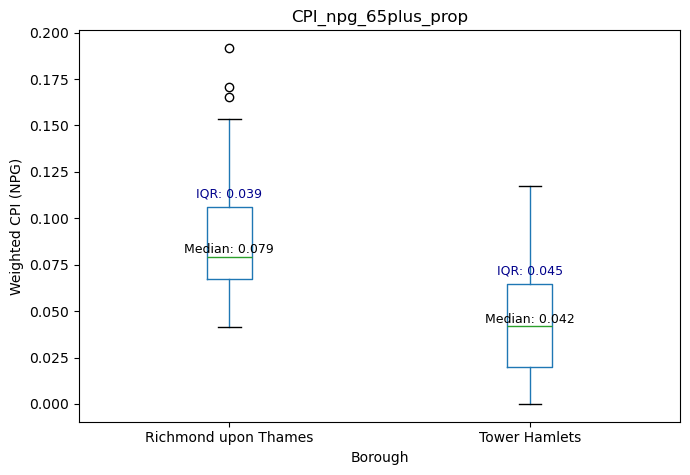

In [48]:


fig, ax = plt.subplots(figsize=(7, 5))

# boxplot
focus_df.boxplot(column='CPI_npg_65plus_prop', by='LAD22NM', ax=ax, grid=False)


plt.suptitle('')
plt.xlabel('Borough')
plt.ylabel('Weighted CPI (NPG)')


groups = focus_df.groupby('LAD22NM')

for i, (name, group) in enumerate(groups):
    q1 = group['CPI_npg_65plus_prop'].quantile(0.25)
    q2 = group['CPI_npg_65plus_prop'].quantile(0.50)  # 中位数
    q3 = group['CPI_npg_65plus_prop'].quantile(0.75)
    iqr = q3 - q1

    ax.text(i + 1, q2 + 0.002, f'Median: {q2:.3f}', ha='center', fontsize=9, color='black')


    ax.text(i + 1, q3 + 0.005, f'IQR: {iqr:.3f}', ha='center', fontsize=9, color='darkblue')


plt.tight_layout()
plt.savefig("Result/65+ Weighted CPI (NPG).png", dpi=300, bbox_inches='tight')
plt.show()


In [49]:
stats = focus_df.groupby('LAD22NM')['CPI_npg_65plus_prop'].describe()
print(stats)

                      count      mean       std       min       25%       50%  \
LAD22NM                                                                         
Richmond upon Thames  115.0  0.088618  0.029401  0.041491  0.067074  0.079060   
Tower Hamlets         175.0  0.044122  0.028757  0.000000  0.019670  0.041839   

                           75%       max  
LAD22NM                                   
Richmond upon Thames  0.106023  0.191636  
Tower Hamlets         0.064465  0.117355  


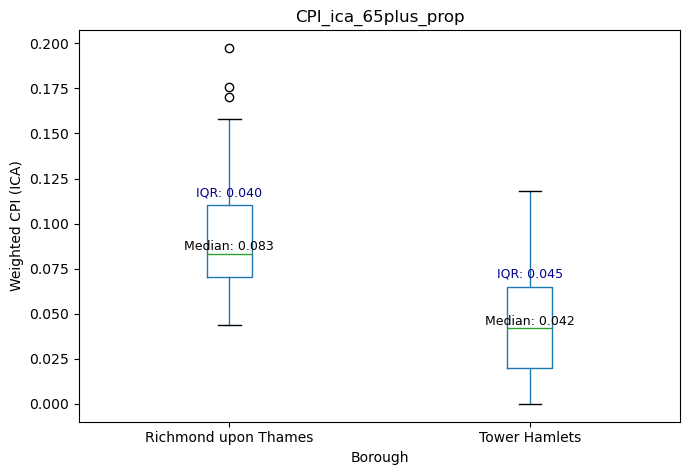

In [50]:

fig, ax = plt.subplots(figsize=(7, 5))


focus_df.boxplot(column='CPI_ica_65plus_prop', by='LAD22NM', ax=ax, grid=False)


plt.suptitle('')
plt.ylabel('Weighted CPI (ICA)')
plt.xlabel('Borough')

groups = focus_df.groupby('LAD22NM')

for i, (name, group) in enumerate(groups):
    q1 = group['CPI_ica_65plus_prop'].quantile(0.25)
    q2 = group['CPI_ica_65plus_prop'].quantile(0.5)  # 中位数
    q3 = group['CPI_ica_65plus_prop'].quantile(0.75)
    iqr = q3 - q1

    ax.text(i + 1, q2 + 0.002, f'Median: {q2:.3f}', ha='center', fontsize=9, color='black')


    ax.text(i + 1, q3 + 0.005, f'IQR: {iqr:.3f}', ha='center', fontsize=9, color='darkblue')

plt.tight_layout()
plt.savefig("Result/65+ Weighted CPI (ICA).png", dpi=300, bbox_inches='tight')
plt.show()

In [51]:
stats = focus_df.groupby('LAD22NM')['CPI_ica_65plus_prop'].describe()
print(stats)

                      count      mean       std       min       25%      50%  \
LAD22NM                                                                        
Richmond upon Thames  115.0  0.092308  0.030173  0.043592  0.070411  0.08314   
Tower Hamlets         175.0  0.044306  0.028856  0.000000  0.019787  0.04200   

                           75%       max  
LAD22NM                                   
Richmond upon Thames  0.110272  0.197314  
Tower Hamlets         0.064983  0.118283  


In [52]:
#!pip install libpysal

In [53]:
#!pip install libpysal esda

In [54]:

th_gdf = focus_gdf[focus_gdf['LAD22NM'] == 'Tower Hamlets'].copy()
rich_gdf = focus_gdf[focus_gdf['LAD22NM'] == 'Richmond upon Thames'].copy()

### --- Tower Hamlets ---npg
w_th = libpysal.weights.Queen.from_dataframe(th_gdf, use_index=True)
w_th.transform = 'R'
print(f"【Tower Hamlets】Number of connected components：{w_th.n_components}")

mi_th = Moran(th_gdf['CPI_npg_65plus_prop'], w_th)
print(f"【Tower Hamlets】Moran's I: {mi_th.I:.4f}")
print(f"【Tower Hamlets】P-value: {mi_th.p_sim:.4f}")

【Tower Hamlets】Number of connected components：1
【Tower Hamlets】Moran's I: 0.5967
【Tower Hamlets】P-value: 0.0010


In [55]:
### --- Richmond ---npg
w_rich = libpysal.weights.Queen.from_dataframe(rich_gdf, use_index=True)
w_rich.transform = 'R'
print(f"【Richmond】Number of connected components：{w_rich.n_components}")

mi_rich = Moran(rich_gdf['CPI_npg_65plus_prop'], w_rich)
print(f"【Richmond】Moran's I: {mi_rich.I:.4f}")
print(f"【Richmond】P-value: {mi_rich.p_sim:.4f}")

【Richmond】Number of connected components：1
【Richmond】Moran's I: 0.3925
【Richmond】P-value: 0.0010


In [56]:
### --- Tower Hamlets ---ica
w_th = libpysal.weights.Queen.from_dataframe(th_gdf, use_index=True)
w_th.transform = 'R'
print(f"【Tower Hamlets】Number of connected components：{w_th.n_components}")

mi_th = Moran(th_gdf['CPI_ica_65plus_prop'], w_th)
print(f"【Tower Hamlets】Moran's I: {mi_th.I:.4f}")
print(f"【Tower Hamlets】P-value: {mi_th.p_sim:.4f}")

【Tower Hamlets】Number of connected components：1
【Tower Hamlets】Moran's I: 0.5937
【Tower Hamlets】P-value: 0.0010


In [57]:
### --- Richmond ---ica
w_rich = libpysal.weights.Queen.from_dataframe(rich_gdf, use_index=True)
w_rich.transform = 'R'
print(f"【Richmond】Number of connected components：{w_rich.n_components}")

mi_rich = Moran(rich_gdf['CPI_ica_65plus_prop'], w_rich)
print(f"【Richmond】Moran's I: {mi_rich.I:.4f}")
print(f"【Richmond】P-value: {mi_rich.p_sim:.4f}")

【Richmond】Number of connected components：1
【Richmond】Moran's I: 0.3768
【Richmond】P-value: 0.0010


In [58]:

def plot_lisa_map(gdf, title, filename=None):
    colors = {
        'High-High': 'red',
        'Low-Low': 'orange',
        'High-Low': 'pink',
        'Low-High': 'lightblue',
        'Not Significant': 'lightgrey'
    }
    gdf['color'] = gdf['LISA_type'].map(colors)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    gdf.plot(color=gdf['color'], edgecolor='grey', linewidth=0.2, ax=ax)
    
    legend_elements = [
        mpatches.Patch(color='red', label='High-High'),
        mpatches.Patch(color='orange', label='Low-Low'),
        mpatches.Patch(color='pink', label='High-Low'),
        mpatches.Patch(color='lightblue', label='Low-High'),
        mpatches.Patch(color='lightgrey', label='Not Significant')
    ]
    ax.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0))

    ax.axis('off')
    ax.set_title(title, fontsize=14)

    if filename:
        plt.tight_layout()
        plt.savefig(filename, dpi=300,bbox_inches='tight')  # 关键参数
    
    plt.show()

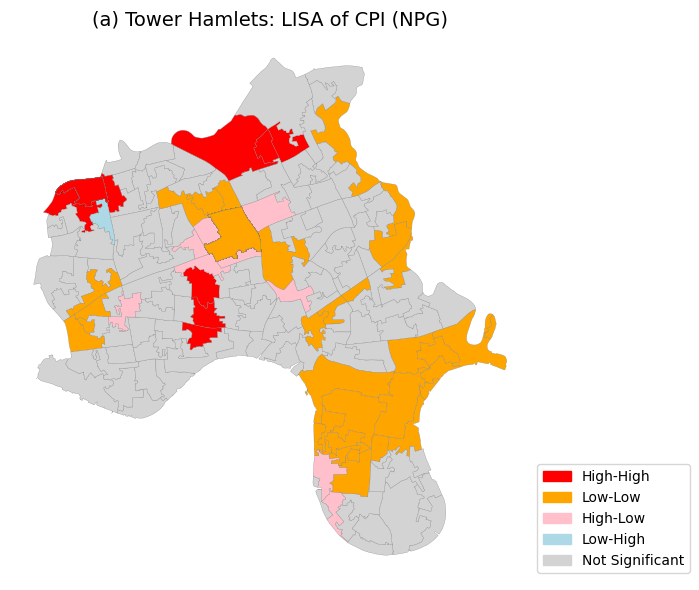

In [59]:
### --- Tower Hamlets LISA (CPI_npg) ---

np.random.seed(42)
w_th = libpysal.weights.Queen.from_dataframe(th_gdf, use_index=True)
w_th.transform = 'R'

lisa_th = Moran_Local(th_gdf['CPI_npg_65plus_prop'], w_th)

th_gdf['LISA_cluster'] = lisa_th.q
th_gdf['significant'] = lisa_th.p_sim < 0.05

cluster_labels = {
    1: 'High-High',
    2: 'Low-High',
    3: 'Low-Low',
    4: 'High-Low'
}
th_gdf['LISA_type'] = th_gdf['LISA_cluster'].map(cluster_labels)
th_gdf.loc[~th_gdf['significant'], 'LISA_type'] = 'Not Significant'


plot_lisa_map(th_gdf, '(a) Tower Hamlets: LISA of CPI (NPG)',filename='Result/Tower_LISA_CPI_NPG.png')

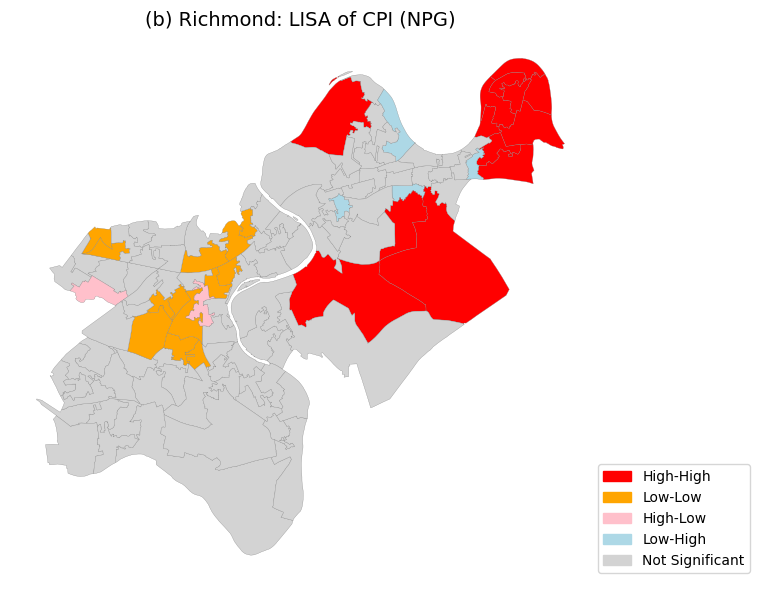

In [60]:
### --- Richmond LISA (CPI_npg)---
np.random.seed(42)
w_rich = libpysal.weights.Queen.from_dataframe(rich_gdf,use_index=True)
w_rich.transform = 'R'

lisa_rich = Moran_Local(rich_gdf['CPI_npg_65plus_prop'], w_rich)

rich_gdf['LISA_cluster'] = lisa_rich.q
rich_gdf['significant'] = lisa_rich.p_sim < 0.05
rich_gdf['LISA_type'] = rich_gdf['LISA_cluster'].map(cluster_labels)
rich_gdf.loc[~rich_gdf['significant'], 'LISA_type'] = 'Not Significant'

plot_lisa_map(rich_gdf,'(b) Richmond: LISA of CPI (NPG)', filename='Result/Richmond_LISA_CPI_NPG.png')

In [61]:
#NPG
# 保存 NPG 的 LISA 结果
th_gdf['LISA_type_npg'] = th_gdf['LISA_type']
rich_gdf['LISA_type_npg'] = rich_gdf['LISA_type']

# --- NPG ---
th_counts_npg = th_gdf['LISA_type_npg'].value_counts().sort_index()
rich_counts_npg = rich_gdf['LISA_type_npg'].value_counts().sort_index()

th_total_npg = th_counts_npg.sum()
rich_total_npg = rich_counts_npg.sum()

th_percent_npg = (th_counts_npg / th_total_npg * 100).round(1).astype(str) + '%'
rich_percent_npg = (rich_counts_npg / rich_total_npg * 100).round(1).astype(str) + '%'

th_display_npg = th_counts_npg.astype(str) + ' (' + th_percent_npg + ')'
rich_display_npg = rich_counts_npg.astype(str) + ' (' + rich_percent_npg + ')'

print('--- Tower Hamlets: NPG ---')
print(th_display_npg)
print('\n--- Richmond upon Thames: NPG ---')
print(rich_display_npg)



--- Tower Hamlets: NPG ---
LISA_type_npg
High-High           73 (24.7%)
High-Low              9 (3.1%)
Low-High              1 (0.3%)
Low-Low             98 (33.2%)
Not Significant    114 (38.6%)
Name: count, dtype: object

--- Richmond upon Thames: NPG ---
LISA_type_npg
High-High          13 (11.3%)
High-Low             2 (1.7%)
Low-High             4 (3.5%)
Low-Low            13 (11.3%)
Not Significant    83 (72.2%)
Name: count, dtype: object


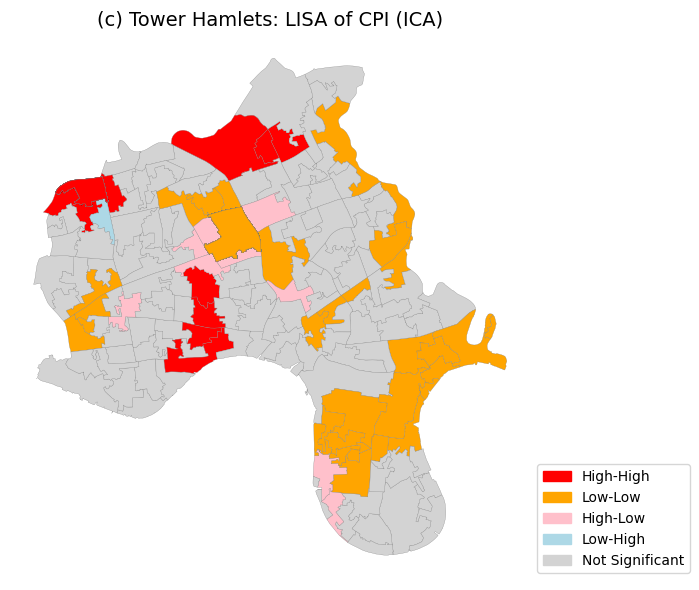

In [62]:
### --- Tower Hamlets LISA (CPI_ica) ---
np.random.seed(42)
w_th = libpysal.weights.Queen.from_dataframe(th_gdf,use_index=True)
w_th.transform = 'R'

lisa_th_ica = Moran_Local(th_gdf['CPI_ica_65plus_prop'], w_th)

th_gdf['LISA_cluster'] = lisa_th_ica.q
th_gdf['significant'] = lisa_th_ica.p_sim < 0.05
th_gdf['LISA_type'] = th_gdf['LISA_cluster'].map(cluster_labels)
th_gdf.loc[~th_gdf['significant'], 'LISA_type'] = 'Not Significant'

plot_lisa_map(th_gdf,'(c) Tower Hamlets: LISA of CPI (ICA)', filename='Result/Tower_LISA_CPI_ICA.png')

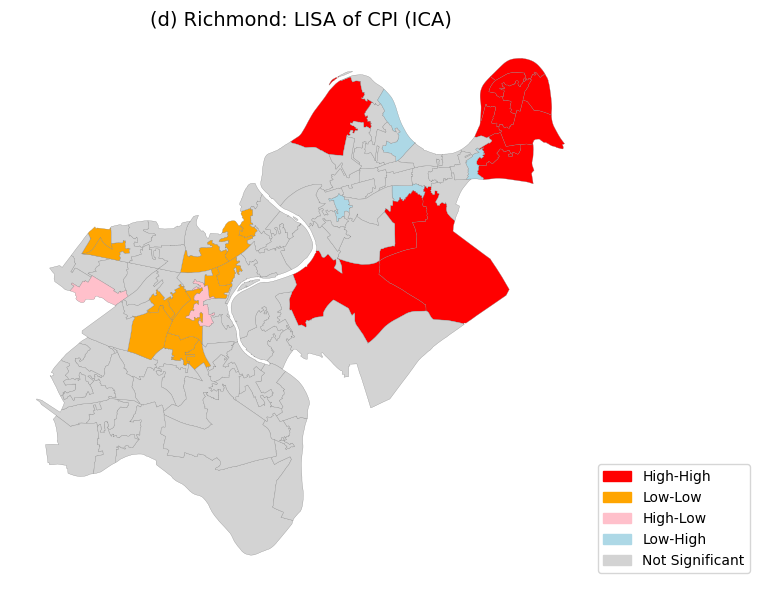

In [63]:
### --- Richmond LISA (CPI_ica) ---
np.random.seed(42)
w_rich = libpysal.weights.Queen.from_dataframe(rich_gdf,use_index=True)
w_rich.transform = 'R'

lisa_rich_ica = Moran_Local(rich_gdf['CPI_ica_65plus_prop'], w_rich)

rich_gdf['LISA_cluster'] = lisa_rich_ica.q
rich_gdf['significant'] = lisa_rich_ica.p_sim < 0.05
rich_gdf['LISA_type'] = rich_gdf['LISA_cluster'].map(cluster_labels)
rich_gdf.loc[~rich_gdf['significant'], 'LISA_type'] = 'Not Significant'

plot_lisa_map(rich_gdf, '(d) Richmond: LISA of CPI (ICA)',filename='Result/Richmond_LISA_CPI_ICA.png')

In [64]:
#ICA

th_gdf['LISA_type_ica'] = th_gdf['LISA_type']
rich_gdf['LISA_type_ica'] = rich_gdf['LISA_type']

# --- ICA ---
th_counts_ica = th_gdf['LISA_type_ica'].value_counts().sort_index()
rich_counts_ica = rich_gdf['LISA_type_ica'].value_counts().sort_index()

th_total_ica = th_counts_ica.sum()
rich_total_ica = rich_counts_ica.sum()

th_percent_ica = (th_counts_ica / th_total_ica * 100).round(1).astype(str) + '%'
rich_percent_ica = (rich_counts_ica / rich_total_ica * 100).round(1).astype(str) + '%'

th_display_ica = th_counts_ica.astype(str) + ' (' + th_percent_ica + ')'
rich_display_ica = rich_counts_ica.astype(str) + ' (' + rich_percent_ica + ')'

print('--- Tower Hamlets: ICA ---')
print(th_display_ica)
print('\n--- Richmond upon Thames: ICA ---')
print(rich_display_ica)


--- Tower Hamlets: ICA ---
LISA_type_ica
High-High           74 (25.1%)
High-Low              9 (3.1%)
Low-High              1 (0.3%)
Low-Low             97 (32.9%)
Not Significant    114 (38.6%)
Name: count, dtype: object

--- Richmond upon Thames: ICA ---
LISA_type_ica
High-High          13 (11.3%)
High-Low             2 (1.7%)
Low-High             4 (3.5%)
Low-Low            13 (11.3%)
Not Significant    83 (72.2%)
Name: count, dtype: object


In [65]:
# Select input variables for clustering
features = ['CPI_npg_65plus_prop', 'CPI_ica_65plus_prop', 'Index of Multiple Deprivation (IMD) Score', 'pop_65plus']

#Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(focus_gdf[features])

In [66]:
# Dimensionality reduction
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(X_scaled)

In [67]:
print("Explained variance ratio：", pca.explained_variance_ratio_)
print("Cumulative explained variance：", pca.explained_variance_ratio_.sum())

Explained variance ratio： [0.71995854 0.21788766]
Cumulative explained variance： 0.9378462056243437


c:\Users\zhouzhou\anaconda3\envs\urbsim\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\zhouzhou\anaconda3\envs\urbsim\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\zhouzhou\anaconda3\envs\urbsim\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\zhouzhou\anaconda3\envs\urbsim\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: 

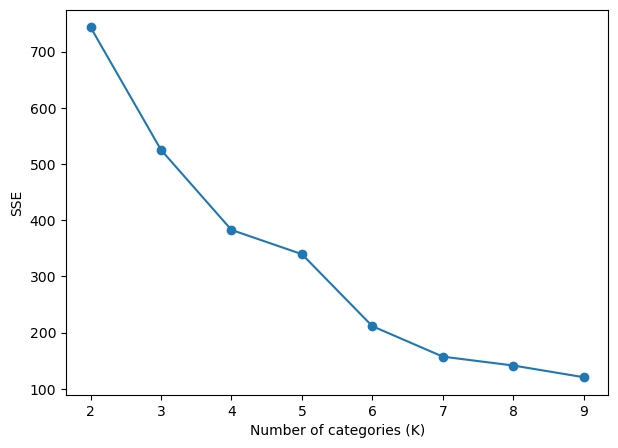

In [68]:
# Elbow method

sse = []
avg_sse = []  
k_range = range(2, 10)
n_samples = len(pca_result)


for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    sse.append(kmeans.inertia_)
    avg_sse.append(kmeans.inertia_ / n_samples)

plt.figure(figsize=(7, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of categories (K)')
plt.ylabel('SSE')

plt.savefig('Result/Elbow method.png', dpi=300)
plt.show()

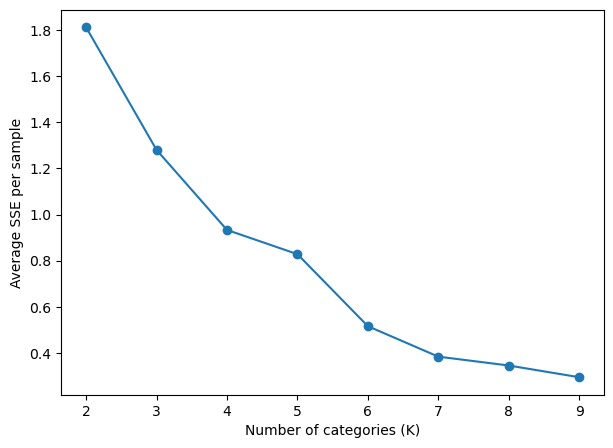

In [69]:
plt.figure(figsize=(7, 5))
plt.plot(k_range, avg_sse, marker='o')
plt.xlabel('Number of categories (K)')
plt.ylabel('Average SSE per sample')

plt.savefig('Result/Average Error per sample.png', dpi=300)
plt.show()

In [70]:
# cluster
kmeans = KMeans(n_clusters=4, random_state=42)
focus_gdf.loc[:, 'cluster_pca'] = kmeans.fit_predict(pca_result)

c:\Users\zhouzhou\anaconda3\envs\urbsim\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\zhouzhou\anaconda3\envs\urbsim\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [71]:
# Calculate mean of each cluster group on the original standardized features
cluster_summary = focus_gdf.groupby('cluster_pca')[features].mean()
print(cluster_summary)

             CPI_npg_65plus_prop  CPI_ica_65plus_prop  \
cluster_pca                                             
0                       0.013662             0.013735   
1                       0.044613             0.044833   
2                       0.090859             0.093662   
3                       0.085106             0.085496   

             Index of Multiple Deprivation (IMD) Score  pop_65plus  
cluster_pca                                                         
0                                            22.130645   31.854839  
1                                            28.335714  166.878571  
2                                            11.476429  274.485714  
3                                            34.788235  233.441176  


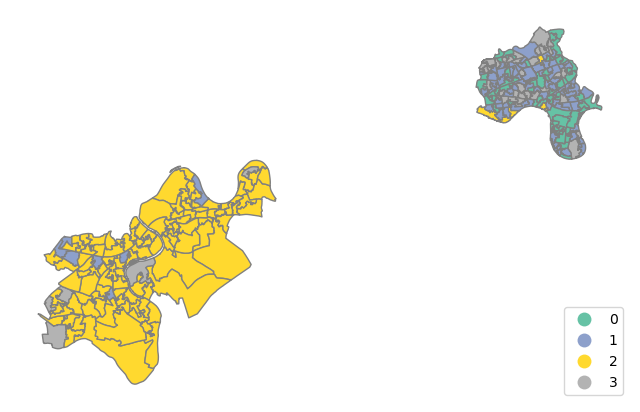

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))


focus_gdf.plot(
    column='cluster_pca',
    categorical=True,
    cmap='Set2',
    legend=True,
    legend_kwds={'loc': 'lower right'},
    ax=ax,
    edgecolor='grey'
)


ax.axis('off')

plt.savefig('Result/Socio-Cultural Accessibility Clusters.png', dpi=300)
plt.show()

In [73]:
# Count the number of units in each district and each category
count_table = focus_gdf.groupby(['LAD22NM', 'cluster_pca']).size().unstack(fill_value=0)

count_table['Total'] = count_table.sum(axis=1)

print(count_table)

cluster_pca            0    1    2   3  Total
LAD22NM                                      
Richmond upon Thames   0    7  103   5    115
Tower Hamlets         62  133   37  63    295


In [74]:
# Calculate percentage
percentage_table = count_table.div(count_table['Total'], axis=0) * 100


formatted_table = count_table.copy()

for col in count_table.columns[:-1]:  # 不包括 'Total' 列
    formatted_table[col] = count_table[col].astype(str) + ' (' + percentage_table[col].round(1).astype(str) + '%)'


print(formatted_table)


cluster_pca                    0            1            2           3  Total
LAD22NM                                                                      
Richmond upon Thames    0 (0.0%)     7 (6.1%)  103 (89.6%)    5 (4.3%)    115
Tower Hamlets         62 (21.0%)  133 (45.1%)   37 (12.5%)  63 (21.4%)    295


In [75]:
print(focus_gdf['LAD22NM'].unique())

['Richmond upon Thames' 'Tower Hamlets']


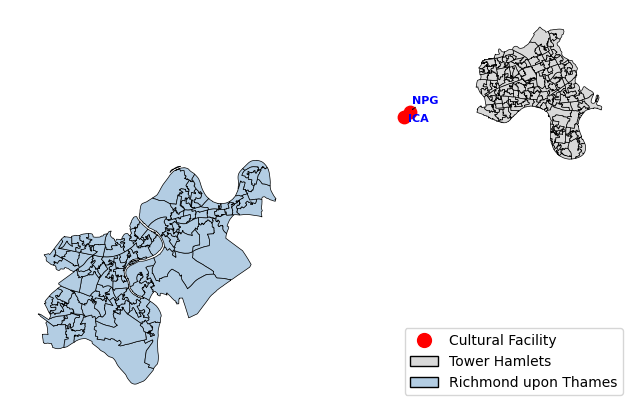

In [76]:

fig, ax = plt.subplots(1, 1, figsize=(8, 6))


borough_colors = {
    'Tower Hamlets': '#d9d9d9',       
    'Richmond upon Thames': '#b3cde3'  
}


for borough, color in borough_colors.items():
    subset = focus_gdf[focus_gdf['LAD22NM'] == borough]
    subset.plot(ax=ax, facecolor=color, edgecolor='black', linewidth=0.5, label=borough)


facilities.plot(ax=ax, color='red', marker='o', markersize=80)


texts = []
for x, y, label in zip(facilities.geometry.x, facilities.geometry.y, facilities['name']):
    texts.append(ax.text(x, y, label, fontsize=8, fontweight='bold', color='blue'))

adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))


facility_marker = plt.Line2D([0], [0], marker='o', color='w', label='Cultural Facility', markerfacecolor='red', markersize=12)
th_patch = plt.Rectangle((0, 0), 1, 1, facecolor='#d9d9d9', edgecolor='black', label='Tower Hamlets')
rich_patch = plt.Rectangle((0, 0), 1, 1, facecolor='#b3cde3', edgecolor='black', label='Richmond upon Thames')

ax.legend(handles=[facility_marker, th_patch, rich_patch], loc='lower right')


ax.axis('off')


plt.savefig('Result/Location_of_NPG_and_ICA.png', dpi=300)
plt.show()

In [77]:

focus_gdf = pd.concat([th_gdf, rich_gdf], axis=0)

# Median threshold
imd_threshold = focus_gdf['Index of Multiple Deprivation (IMD) Score'].median()
age_threshold = focus_gdf['pop_65plus'].median()

# Classification function (2 conditions met => very high vulnerability; 1 condition met => potential vulnerability)
def classify_zone(row):
    score = 0
    if row['LISA_type'] == 'Low-Low':
        score += 1
    if row['Index of Multiple Deprivation (IMD) Score'] > imd_threshold:
        score += 1
    if row['pop_65plus'] > age_threshold:
        score += 1

    if score >= 2:
        return 'Cultural & Social Vulnerable Zone'
    elif score == 1:
        return 'Potentially Vulnerable Zone'
    else:
        return 'Other'


focus_gdf['vulnerable_zone'] = focus_gdf.apply(classify_zone, axis=1)

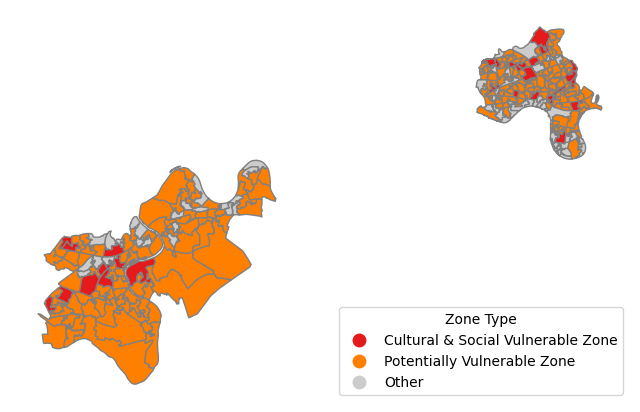

In [78]:
cmap = ListedColormap(['#e41a1c', '#ff7f00', '#cccccc'])


category_order = ['Cultural & Social Vulnerable Zone', 'Potentially Vulnerable Zone', 'Other']
focus_gdf['vulnerable_zone'] = pd.Categorical(focus_gdf['vulnerable_zone'], categories=category_order, ordered=True)


fig, ax = plt.subplots(1, 1, figsize=(8, 6))
focus_gdf.plot(
    column='vulnerable_zone',
    categorical=True,
    cmap=cmap,
    legend=True,
    legend_kwds={'loc': 'lower right', 'title': 'Zone Type'},
    ax=ax,
    edgecolor='grey'
)

ax.axis('off')

plt.savefig('Result/Cultural & Social Vulnerable Zones.png', dpi=300)

plt.show()

In [79]:
# Count the number of vulnerable areas in each district
zone_count = (
    focus_gdf.groupby(['LAD22NM', 'vulnerable_zone'], observed=True)  # 显式设定
    .size()
    .unstack(fill_value=0)
)

zone_count['Total'] = zone_count.sum(axis=1)

# calculate percentage
zone_percent = zone_count.div(zone_count['Total'], axis=0) * 100
zone_percent = zone_percent.round(1).astype(str) + '%'


zone_display = zone_count.astype(str) + ' (' + zone_percent + ')'
zone_display

vulnerable_zone,Cultural & Social Vulnerable Zone,Potentially Vulnerable Zone,Other,Total
LAD22NM,,,,
Richmond upon Thames,10 (8.7%),83 (72.2%),22 (19.1%),115 (100.0%)
Tower Hamlets,113 (38.3%),145 (49.2%),37 (12.5%),295 (100.0%)


In [80]:
# NPG
npg_lat = 51.50888716
npg_lon = -0.126871767

# Retrieve the pedestrian network within a 5,000 m radius centred on each facility
G = ox.graph_from_point((npg_lat, npg_lon), dist=5000, network_type="walk")

In [81]:
# Identify the nearest network node
npg_node = ox.distance.nearest_nodes(G, npg_lon, npg_lat)

In [82]:
# Calculate 15-minute walking distance (assuming walking speed = 1.14 m/s, 15 minutes = 1026 meters):
isochrone_distance = 1026

In [83]:
# Extract 15-minute isochrone subgraph
subgraph = nx.ego_graph(G, npg_node, radius=isochrone_distance, distance="length")

In [84]:

lsoa_gdf = gpd.read_file('Lower_layer_Super_Output_Areas_(December_2021)_Boundaries_EW_BFC_(V10).shp')
lsoa_gdf = lsoa_gdf.to_crs("EPSG:4326")

In [85]:

nodes = list(subgraph.nodes)
node_coords = [Point((G.nodes[n]['x'], G.nodes[n]['y'])) for n in nodes]


polygon_geom = unary_union(node_coords).convex_hull
polygon_gdf = gpd.GeoDataFrame(geometry=[polygon_geom], crs="EPSG:4326")


polygon_gdf = polygon_gdf.to_crs(lsoa_gdf.crs)

In [86]:
# Perform spatial intersection to retain LSOAs within the isochrone
lsoa_in_iso_npg = gpd.sjoin(lsoa_gdf, polygon_gdf, how="inner", predicate="intersects")


print(lsoa_in_iso_npg[["LSOA21CD"]])
print(f"A total of {len(lsoa_in_iso_npg)} LSOAs fall within the isochrone")

        LSOA21CD
815    E01000850
818    E01000855
879    E01000918
880    E01000919
2867   E01003013
2870   E01003016
4477   E01004731
4479   E01004733
4480   E01004734
4481   E01004735
4482   E01004736
4504   E01004763
30922  E01032582
33709  E01035716
A total of 14 LSOAs fall within the isochrone


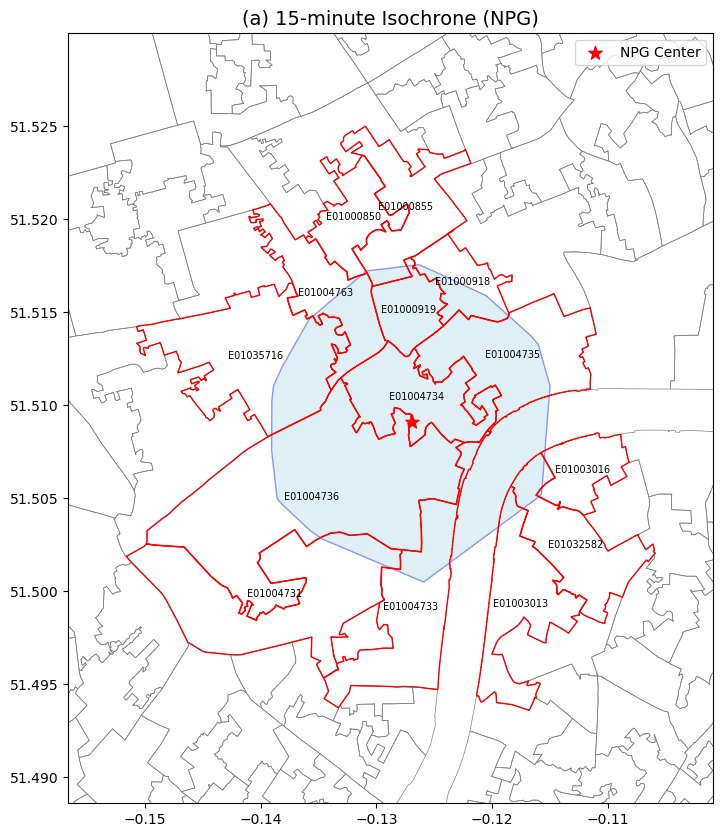

In [87]:

projected = lsoa_in_iso_npg.to_crs(epsg=3857)

# Calculate centroid
projected["centroid"] = projected.geometry.centroid


lsoa_in_iso_npg["centroid"] = projected["centroid"].to_crs(lsoa_in_iso_npg.crs)


fig, ax = plt.subplots(figsize=(10, 10))


lsoa_gdf.boundary.plot(ax=ax, color="grey", linewidth=0.5)
polygon_gdf.plot(ax=ax, facecolor="lightblue", edgecolor="blue", alpha=0.4)
lsoa_in_iso_npg.boundary.plot(ax=ax, color="red", linewidth=1)


for idx, row in lsoa_in_iso_npg.iterrows():
    x, y = row["centroid"].x, row["centroid"].y
    ax.text(x, y, row["LSOA21CD"], fontsize=7, ha="center", va="center", color="black")


npg_x = G.nodes[npg_node]["x"]
npg_y = G.nodes[npg_node]["y"]
ax.scatter(npg_x, npg_y, color="red", s=100, marker="*", label="NPG Center", zorder=5)

minx, miny, maxx, maxy = lsoa_in_iso_npg.total_bounds
buffer = 0.005
ax.set_xlim(minx - buffer, maxx + buffer)
ax.set_ylim(miny - buffer, maxy + buffer)

ax.set_title("(a) 15-minute Isochrone (NPG)", fontsize=14)
plt.legend()


plt.savefig('Result/LSOA within 15-minute Isochrone (NPG).png', dpi=300)
plt.show()

In [88]:
#ICA
ica_lat = 51.490553
ica_lon = -0.12926452

G = ox.graph_from_point((ica_lat, ica_lon), dist=5000, network_type="walk")

In [89]:

ica_node = ox.distance.nearest_nodes(G, ica_lon, ica_lat)

In [90]:

isochrone_distance = 1026

subgraph_ica = nx.ego_graph(G, ica_node, radius=isochrone_distance, distance="length")

In [91]:

edges_ica = ox.graph_to_gdfs(subgraph_ica, nodes=False)

lines = list(edges_ica.geometry)
mls = MultiLineString(lines)
polygon_ica = mls.convex_hull

polygon_ica_gdf = gpd.GeoDataFrame(geometry=[polygon_ica], crs="EPSG:4326")

In [92]:

lsoa_gdf = lsoa_gdf.to_crs("EPSG:4326")


lsoa_in_iso_ica = gpd.sjoin(lsoa_gdf, polygon_ica_gdf, how="inner", predicate="intersects")

print(lsoa_in_iso_ica[["LSOA21CD"]])
print(f"A total of {len(lsoa_in_iso_ica)} LSOAs fall within the ICA 15-minute isochrone")

        LSOA21CD
2956   E01003102
4420   E01004665
4422   E01004669
4477   E01004731
4478   E01004732
4479   E01004733
4483   E01004737
4484   E01004740
4485   E01004741
4486   E01004742
4487   E01004743
4488   E01004744
4489   E01004746
4490   E01004747
4491   E01004748
4492   E01004749
4495   E01004752
4496   E01004753
31410  E01033208
31903  E01033862
31904  E01033863
31906  E01033865
33490  E01035496
33712  E01035719
33713  E01035720
33715  E01035722
A total of 26 LSOAs fall within the ICA 15-minute isochrone


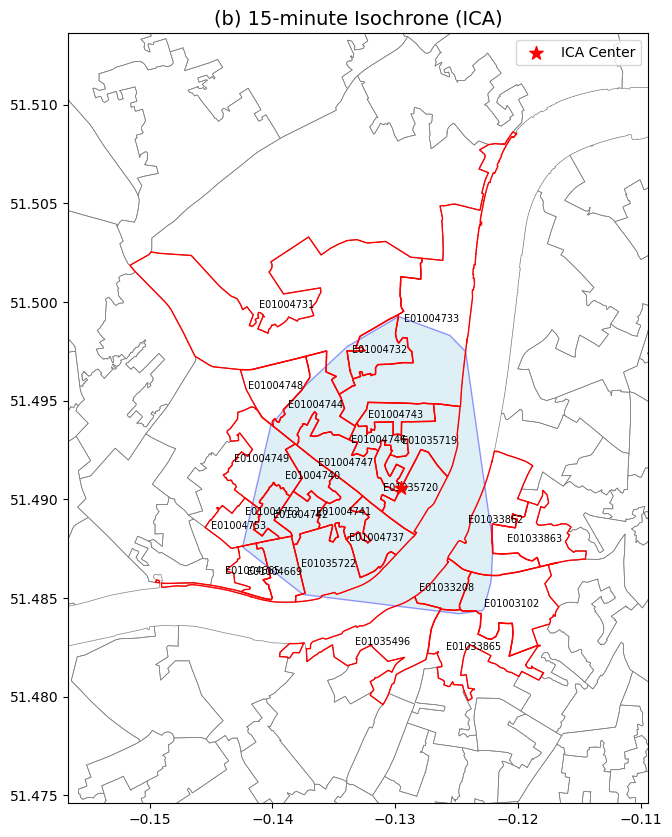

In [93]:

projected_ica = lsoa_in_iso_ica.to_crs(epsg=3857)


projected_ica["centroid"] = projected_ica.geometry.centroid


lsoa_in_iso_ica["centroid"] = projected_ica["centroid"].to_crs(lsoa_in_iso_ica.crs)


fig, ax = plt.subplots(figsize=(10, 10))
lsoa_gdf.boundary.plot(ax=ax, color="grey", linewidth=0.5)
polygon_ica_gdf.plot(ax=ax, facecolor="lightblue", edgecolor="blue", alpha=0.4)
lsoa_in_iso_ica.boundary.plot(ax=ax, color="red", linewidth=1)


for idx, row in lsoa_in_iso_ica.iterrows():
    x, y = row["centroid"].x, row["centroid"].y
    ax.text(x, y, row["LSOA21CD"], fontsize=7, ha="center", va="center", color="black")


ica_x = G.nodes[ica_node]["x"]
ica_y = G.nodes[ica_node]["y"]
ax.scatter(ica_x, ica_y, color="red", s=100, marker="*", label="ICA Center", zorder=5)


minx, miny, maxx, maxy = lsoa_in_iso_ica.total_bounds
buffer = 0.005
ax.set_xlim(minx - buffer, maxx + buffer)
ax.set_ylim(miny - buffer, maxy + buffer)


ax.set_title("(b) 15-minute Isochrone (ICA)", fontsize=14)
plt.legend()

plt.savefig('Result/LSOA within 15-minute Isochrone (ICA).png', dpi=300)
plt.show()

In [94]:

cpi_vars = ['CPI_npg_65plus_prop', 'CPI_ica_65plus_prop']


social_vars = ['prop_65plus', 'Index of Multiple Deprivation (IMD) Score']

results = []

# Pearson
for cpi in cpi_vars:
    for soc in social_vars:
        x = focus_gdf[cpi]
        y = focus_gdf[soc]
        corr, p_val = pearsonr(x, y)
        results.append({
            'CPI Indicator': cpi,
            'Social Variable': soc,
            'Pearson r': round(corr, 3),
            'p-value': round(p_val, 4)
        })

In [95]:

pearson_df = pd.DataFrame(results)

print(pearson_df)

         CPI Indicator                            Social Variable  Pearson r  \
0  CPI_npg_65plus_prop                                prop_65plus      0.884   
1  CPI_npg_65plus_prop  Index of Multiple Deprivation (IMD) Score     -0.267   
2  CPI_ica_65plus_prop                                prop_65plus      0.900   
3  CPI_ica_65plus_prop  Index of Multiple Deprivation (IMD) Score     -0.295   

   p-value  
0      0.0  
1      0.0  
2      0.0  
3      0.0  


In [96]:
end_time = time.time() 
runtime_minutes = (end_time - start_time) / 60
print(f"Runtime: {runtime_minutes:.2f} minutes")

Runtime: 10.76 minutes
